# 2D Path Planning using Potential Field Method

This notebook implements a path planning algorithm to navigate from a randomly chosen start point to a goal point in a 2D workspace, avoiding circular obstacles using the potential field method. The workspace (start, goal, and obstacles) is generated randomly with validation to ensure feasibility. The algorithm includes a mechanism to escape local minima and visualizes the path and potential field.

The code is designed for Google Colab, requiring only NumPy and Matplotlib, which are pre-installed in Colab.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility of random workspace generation
np.random.seed(42)

# Define workspace boundaries (2D rectangular area)
# X_MIN, X_MAX: x-coordinate bounds
# Y_MIN, Y_MAX: y-coordinate bounds
X_MIN, X_MAX = -1, 6
Y_MIN, Y_MAX = -1, 6

## Workspace Generation

The following functions generate a random workspace, including a start point, goal point, and circular obstacles. The `is_point_valid` function ensures points do not lie inside obstacles, and `generate_workspace` creates a feasible configuration where start and goal are sufficiently far apart, and obstacles do not overlap excessively with each other or the start/goal points.

In [2]:
def is_point_valid(point, obstacles, min_dist=0.1):
    """Check if a point is not inside any obstacle.

    Args:
        point (np.ndarray): 2D point [x, y] to check.
        obstacles (list): List of tuples [(center, radius), ...], where center is [x, y] and radius is a float.
        min_dist (float): Minimum distance buffer from obstacle boundaries.

    Returns:
        bool: True if point is outside all obstacles, False otherwise.
    """
    for (center, radius) in obstacles:
        if np.linalg.norm(point - center) <= radius + min_dist:
            return False
    return True

def generate_workspace(num_obstacles=3, min_radius=0.5, max_radius=1.0):
    """Generate random start point, goal point, and obstacles within the workspace.

    Args:
        num_obstacles (int): Number of circular obstacles to generate.
        min_radius (float): Minimum radius of obstacles.
        max_radius (float): Maximum radius of obstacles.

    Returns:
        tuple: (q_start, q_goal, obstacles), where q_start and q_goal are 2D points [x, y],
               and obstacles is a list of [(center, radius), ...].
    """
    while True:
        # Randomly generate start and goal points within workspace bounds
        q_start = np.random.uniform([X_MIN, Y_MIN], [X_MAX, Y_MAX])
        q_goal = np.random.uniform([X_MIN, Y_MIN], [X_MAX, Y_MAX])
        obstacles = []
        # Ensure start and goal are at least 2 units apart for a meaningful path
        if np.linalg.norm(q_start - q_goal) > 2.0:
            for _ in range(num_obstacles):
                while True:
                    # Generate random obstacle center and radius
                    center = np.random.uniform([X_MIN, Y_MIN], [X_MAX, Y_MAX])
                    radius = np.random.uniform(min_radius, max_radius)
                    obstacle = (center, radius)
                    # Check if obstacle is valid (does not overlap with start, goal, or other obstacles)
                    if (is_point_valid(center, obstacles) and
                        is_point_valid(q_start, [obstacle]) and
                        is_point_valid(q_goal, [obstacle])):
                        obstacles.append(obstacle)
                        break
            if len(obstacles) == num_obstacles:
                break
    return q_start, q_goal, obstacles

# Generate and print the workspace configuration
q_start, q_goal, obstacles = generate_workspace(num_obstacles=3)
print(f"Start Point: {q_start}")
print(f"Goal Point: {q_goal}")
print(f"Obstacles: {obstacles}")

Start Point: [1.62178083 5.65500014]
Goal Point: [4.12395759 3.19060939]
Obstacles: [(array([0.09213048, 0.09196164]), 0.5290418060840998), (array([-0.85590854,  5.78936897]), 0.9162213204002109), (array([1.1296957 , 2.67329502]), 0.7159725093210578)]


## Potential Field Functions

The potential field method models the workspace as a field where the goal attracts the robot (attractive potential) and obstacles repel it (repulsive potential). The total potential is the sum of these, and the robot moves along the negative gradient of the total potential. The following functions compute the potentials and their gradients.

In [3]:
# Define potential field parameters
K_att = 1.0    # Attractive gain (controls strength of attraction to goal)
K_rep = 100.0  # Repulsive gain (controls strength of repulsion from obstacles)
d0 = 1.0       # Obstacle influence radius (distance beyond which repulsion is zero)

def U_att(q, q_goal):
    """Compute attractive potential (quadratic) toward the goal.

    Args:
        q (np.ndarray): Current position [x, y].
        q_goal (np.ndarray): Goal position [x, y].

    Returns:
        float: Attractive potential value.
    """
    return 0.5 * K_att * np.linalg.norm(q - q_goal)**2

def U_rep(q, q_obs, radius):
    """Compute repulsive potential from a circular obstacle.

    Args:
        q (np.ndarray): Current position [x, y].
        q_obs (np.ndarray): Obstacle center [x, y].
        radius (float): Obstacle radius.

    Returns:
        float: Repulsive potential value (infinite if inside obstacle).
    """
    d = np.linalg.norm(q - q_obs) - radius
    if d <= 0:
        return np.inf
    if d <= d0:
        return 0.5 * K_rep * (1.0/d - 1.0/d0)**2
    return 0.0

def grad_U_att(q, q_goal):
    """Compute gradient of attractive potential.

    Args:
        q (np.ndarray): Current position [x, y].
        q_goal (np.ndarray): Goal position [x, y].

    Returns:
        np.ndarray: Gradient vector [dx, dy].
    """
    return K_att * (q - q_goal)

def grad_U_rep(q, q_obs, radius):
    """Compute gradient of repulsive potential.

    Args:
        q (np.ndarray): Current position [x, y].
        q_obs (np.ndarray): Obstacle center [x, y].
        radius (float): Obstacle radius.

    Returns:
        np.ndarray: Gradient vector [dx, dy].
    """
    vec = q - q_obs
    dist = np.linalg.norm(vec) - radius
    if dist <= 0 or dist > d0:
        return np.zeros(2)
    d = dist
    grad = K_rep * (1.0/d0 - 1.0/d) * (1.0/(d**2)) * (vec / np.linalg.norm(vec))
    return grad

def U_total(q):
    """Compute total potential at point q (sum of attractive and repulsive potentials).

    Args:
        q (np.ndarray): Current position [x, y].

    Returns:
        float: Total potential value.
    """
    U = U_att(q, q_goal)
    for (q_obs, rad) in obstacles:
        U += U_rep(q, q_obs, rad)
    return U

def grad_U_total(q):
    """Compute gradient of total potential.

    Args:
        q (np.ndarray): Current position [x, y].

    Returns:
        np.ndarray: Gradient vector [dx, dy].
    """
    grad = grad_U_att(q, q_goal)
    for (q_obs, rad) in obstacles:
        grad += grad_U_rep(q, q_obs, rad)
    return grad

## Gradient Descent Path Planning

The gradient descent algorithm moves the robot from the start point to the goal by following the negative gradient of the total potential. A perturbation mechanism helps escape local minima, and stagnation detection prevents the algorithm from running indefinitely if stuck.

In [4]:
# Gradient descent parameters
step_size = 0.1           # Size of each step along the negative gradient
max_iters = 1000          # Maximum number of iterations
tolerance = 0.1           # Distance to goal to consider it reached
min_step_threshold = 1e-4 # Threshold for detecting stagnation (small movement)
perturbation_scale = 0.5  # Scale for random perturbations to escape local minima

# Initialize path with the start point
path = [q_start.copy()]
q = q_start.copy()        # Current position
prev_q = q.copy()         # Previous position for stagnation detection
stagnation_count = 0      # Counter for stagnation detection
max_stagnation = 50      # Max iterations to consider stagnation

for i in range(max_iters):
    # Compute the gradient of the total potential at current position
    grad = grad_U_total(q)
    if np.linalg.norm(grad) < 1e-6:  # Check for near-zero gradient (local minimum)
        # Apply random perturbation to escape potential local minimum
        q = q + np.random.uniform(-perturbation_scale, perturbation_scale, size=2)
        if not is_point_valid(q, obstacles):
            q = prev_q  # Revert to previous position if perturbation lands inside obstacle
        stagnation_count += 1
    else:
        # Move in the direction of the negative gradient
        q = q - step_size * grad
        if not is_point_valid(q, obstacles):
            q = prev_q  # Revert to previous position if step lands inside obstacle
        stagnation_count = 0
    path.append(q.copy())

    # Check for stagnation (negligible movement)
    if np.linalg.norm(q - prev_q) < min_step_threshold:
        stagnation_count += 1
    else:
        stagnation_count = 0
    prev_q = q.copy()

    # Check if goal is reached (within tolerance)
    if np.linalg.norm(q - q_goal) < tolerance:
        print(f"Reached goal in {i+1} steps.")
        break
    # Check for stagnation
    if stagnation_count > max_stagnation:
        print(f"Stagnation detected after {i+1} steps.")
        break
else:
    print("Max iterations reached before reaching goal.")

# Convert path to numpy array for plotting
path = np.array(path)

Reached goal in 34 steps.


## Visualization

This cell visualizes the workspace, including the start point (green circle), goal point (red star), obstacles (red circles), and the computed path (blue line). Contours of the total potential field are plotted to illustrate the attractive and repulsive forces influencing the path.

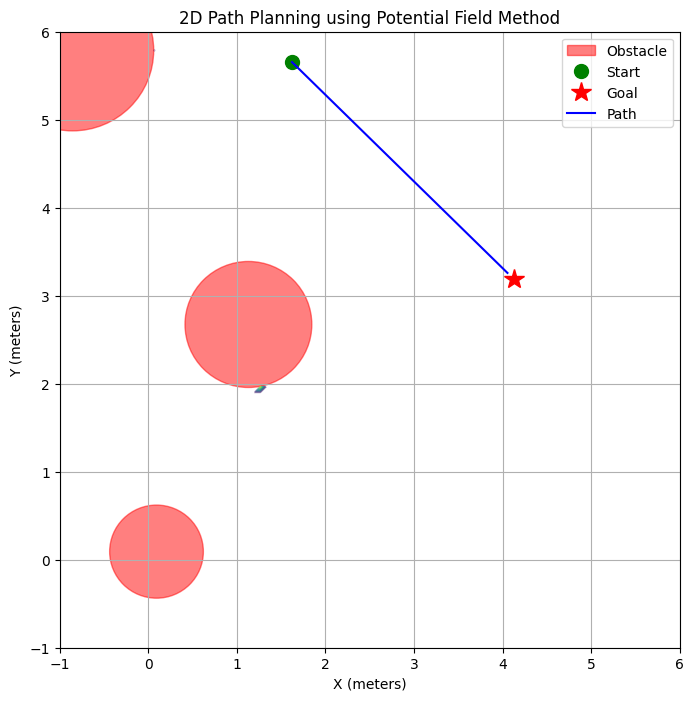

In [5]:
# Create a figure for visualization
fig, ax = plt.subplots(figsize=(8, 8))

# Plot obstacles as red circles
for (q_obs, rad) in obstacles:
    circle = plt.Circle(q_obs, rad, color='red', alpha=0.5, label='Obstacle' if q_obs is obstacles[0][0] else "")
    ax.add_patch(circle)

# Plot start point (green circle) and goal point (red star)
ax.plot(q_start[0], q_start[1], 'go', label='Start', markersize=10)
ax.plot(q_goal[0], q_goal[1], 'r*', label='Goal', markersize=15)

# Plot the computed path as a blue line
ax.plot(path[:, 0], path[:, 1], 'b-', label='Path')

# Generate potential field contours for visualization
x = np.linspace(X_MIN, X_MAX, 100)
y = np.linspace(Y_MIN, Y_MAX, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = U_total(np.array([X[i, j], Y[i, j]]))
        if np.isinf(Z[i, j]):
            Z[i, j] = np.nan  # Replace infinite potentials (inside obstacles) with NaN to avoid plotting issues
ax.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.3)

# Add legend, set plot limits, and labels
ax.legend()
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.set_title("2D Path Planning using Potential Field Method")
ax.set_xlabel('X (meters)')
ax.set_ylabel('Y (meters)')
ax.grid(True)
plt.show()